In [1]:
import pyfair

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import numpy as np
import os

In [2]:
import pyfair

from pyfair.report.base_report import FairBaseReport

In [3]:
model1 = pyfair.FairModel(name="HA1", n_simulations=10_000)
model1.input_data('Loss Event Frequency', low=20, mode=100, high=900)
model1.input_data('Probable Loss Magnitude', low=3_000_000, mode=3_500_000, high=5_000_000)
model1.calculate_all()

model2 = pyfair.FairModel(name="HA2", n_simulations=10_000)
model2.input_data('Loss Event Frequency', low=.5, mode=.7, high=.9)
model2.input_data('Probable Loss Magnitude', low=2_000_000_000, mode=3_000_000_000, high=5_000_000_000)
model2.calculate_all()

model3 = pyfair.FairModel(name="HA3", n_simulations=10_000)
model3.input_data('Loss Event Frequency', low=10, mode=15, high=16)
model3.input_data('Probable Loss Magnitude', low=500_000_000, mode=500_900_000, high=600_000_000)
model3.calculate_all()

#fr = FairReport(model1)
#fr.to_html('C:/Users/theon/Desktop/report.html')
results = model1.export_results()
node_statuses = model1.get_node_statuses()

C:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\lib\site-packages\scipy\stats\_continuous_distns.py:437: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)


Exception: 

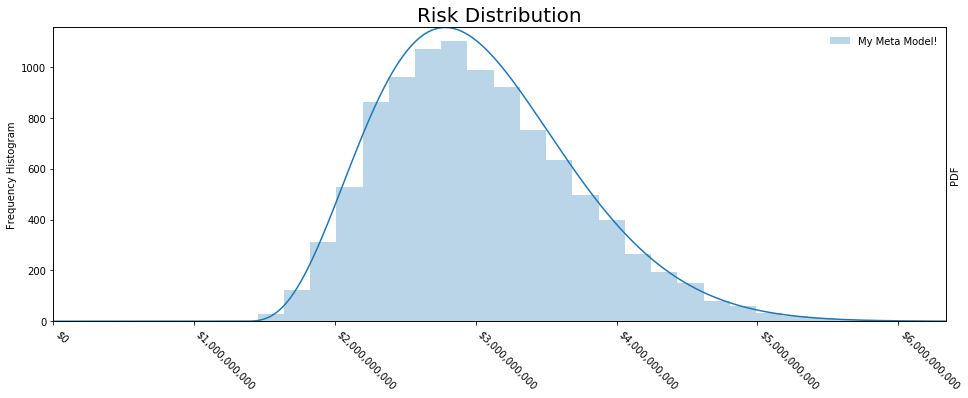

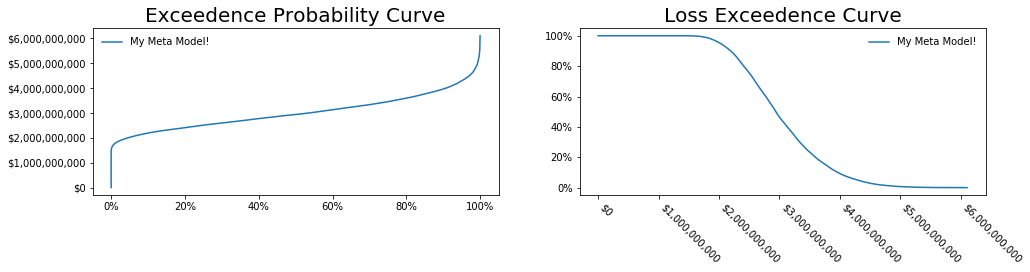

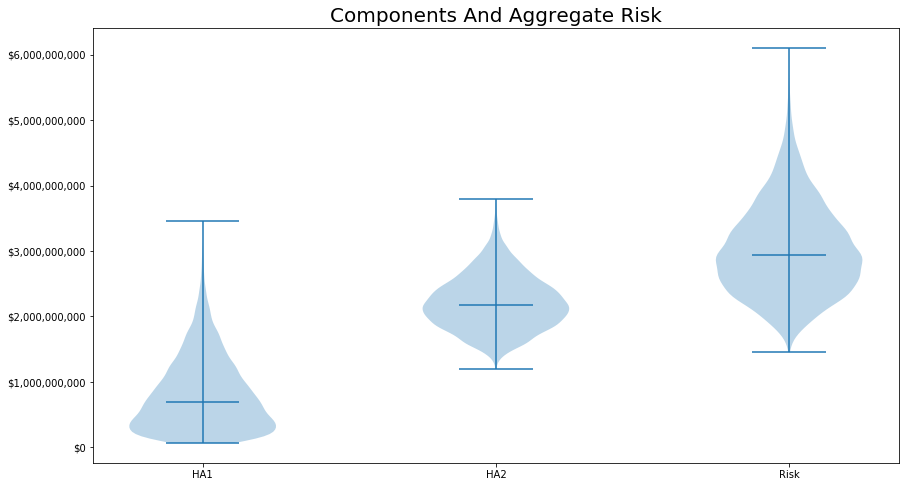

In [4]:
import pandas as pd


class FairSimpleReport(FairBaseReport):
    
    def __init__(self, model):
        super().__init__()
        self._model = model
        self._css = self._template_paths['css'].read_text()
        self._template = self._template_paths['simple'].read_text()
        
    def _construct_output(self):
        '''Function called by FairBaseReport.to_html()'''
        
        # Alias
        t = self._template
        # Add css
        t = t.replace('{STYLE}', self._css)
        # Add Metadata
        t = t.replace('{METADATA}', self._get_metadata_table())
        # Get logo tag
        b64 = self.base64ify(self._logo_location)
        t = t.replace('{PYTHON_LOGO}', b64)

        # Overview Table
        data = self._model.export_results()
        risk = data['Risk']
        # Shoud this be done within model?
        overview_df = pd.DataFrame(
            columns=['Risk'],
            index=['Mean', 'Stdev', 'Maximum', 'Minimum'],
            data=[risk.mean(), risk.std(), risk.max(), risk.min()]
        )
        overview_df = overview_df.applymap(lambda x: self._format_strings['Risk'].format(x))
        overview_df.loc['Simulations'] = '{0:,.0f}'.format(len(risk))
        overview_df.loc['Identifier'] = self._model.get_uuid()
        overview_df.loc['Model Type'] = self._model.__class__.__name__
        overview_html = overview_df.to_html(border=0, header=True, justify='left', classes='fair_table')
        t = t.replace('{OVERVIEW_DATAFRAME}', overview_html)
        
        # Overview Hist
        hist = self._get_distribution(self._model)
        t = t.replace('{HIST}', hist)
        
        # Overview Exceedence Curves
        exceed = self._get_exceedence_curves(self._model)
        t = t.replace('{EXCEEDENCE}', exceed)
        
        # # Detail Image
        detail_img = ''
        if self._model.__class__.__name__ == 'FairModel':
            detail_img += self._get_tree(self._model)
        if self._model.__class__.__name__ == 'FairMetaModel':
            detail_img += self._get_violins(self._model)
        t = t.replace('{PARAMETER_IMG}', detail_img)
        
        # Detail table
        if self._model.__class__.__name__ == 'FairModel':
            detail_table = ''
            params = self._model.export_params()
            fs = self._format_strings
            try:
                del params['Creation Datetime']
            except KeyError:
                pass
            param_df = pd.DataFrame(params).T
            param_df = param_df[['low', 'mode', 'high']]
            param_df['mean'] = self._model.export_results().mean(axis=0)
            param_df['stdev'] = self._model.export_results().std(axis=0)
            param_df['min'] = self._model.export_results().min(axis=0)
            param_df['max'] = self._model.export_results().max(axis=0)
            param_df = param_df.apply(
                lambda row: pd.Series(
                    [fs[row.name].format(item) for item in row],
                    index=row.index.values
                ),
                axis=1,
            )
            # Do not truncate our base64 images.
            param_df['distribution'] = [
                self._get_distribution_icon(self._model, target)
                for target 
                in param_df.index.values
            ]
            pd.set_option('display.max_colwidth', -1)
            detail_table += param_df.to_html(
                border=0, 
                header=True, 
                justify='left', 
                classes='fair_table',
                escape=False
            )
            t = t.replace('{PARAMETER_TABLE}', detail_table)
        if self._model.__class__.__name__ == 'FairMetaModel':
            detail_table = ''
            risk_df = self._model.export_results().T
            risk_df = pd.DataFrame({
                'mean' : risk_df.mean(axis=1),
                'stdev': risk_df.std(axis=1),
                'min'  : risk_df.min(axis=1),
                'max'  : risk_df.max(axis=1),
            })

            risk_df = risk_df.apply(
                lambda row: pd.Series(
                    [self._format_strings['Risk'].format(item) for item in row],
                    index=row.index.values
                ),
                axis=1,
            )
            # Do not truncate our base64 images.
            detail_table += risk_df.to_html(
                border=0, 
                header=True, 
                justify='left', 
                classes='fair_table',
                escape=False
            )
            t = t.replace('{PARAMETER_TABLE}', detail_table)
            
        # Source
        t = t.replace('{JSON}', self._model.to_json())
        source = self._get_caller_source()
        # Replace tags
        source.replace('<', '').replace('>','')
        t = t.replace('{SOURCE}', source)
            
            
        return t

mm = pyfair.FairMetaModel(name='My Meta Model!', models=[model1, model2])
mm.calculate_all()

fsr = FairSimpleReport(mm)
fsr.to_html('output.html')

raise Exception()

# Components

<section header and metadata>

<section overview>

* Summary General
    * Summary Table (mean, stdev, low, high, n)
    * hist
    * Exceedence curves
* Summary Comparison
    * Summary Table (mean, stdev, low, high, n)
    * Summary Table 2
    * Combined Hist
    * Exceedence curves
    
<section parameters>

* Model Detail
    * Parameter table with distributions
* Metamodel Detail
    * Risk table with stacked area
    
<section> and source code
* JSON

# Reports
* Compare
* Single
* Metamodel Drilldown

In [ ]:

mm = pyfair.FairMetaModel(name='MetaModel1', models=[model1, model2, model3])

mm.export_results()

In [ ]:
from pyfair.report.distribution import FairDistributionCurve

fdc = FairDistributionCurve([model1, model2, model3])
#fig, ax = fdc.generate_image()

fig, ax = fdc.generate_image()
fdc.generate_icon('HA1', 'Risk')

In [ ]:
from pyfair.report.exceedence import FairExceedenceCurves

fpc = FairExceedenceCurves([model1, model2, model3])
fig1, ax1 = fpc.generate_image()

In [ ]:
'''
FairModel
    Just one
FairAddititveMetaModel
    Add all the risks together and display with components
FairComparativeMetaModel
    Put risks side by side
    
Mu, Sigma for Risk

Model Params

Source
'''